# CH5. 분류(Classification)
 - 여러 카테고리 중 어디에 속할지 예측하는 것이 목표
 
 - 모델에 단순히 이진 분류 결과를 할당하는 대신, 대부분의 알고리즘은 관심 클래스에 속할 확률 점수(경향, propensity)을 반환
 
 
 - 일반적인 접근 방식:
 1. 어떤 레코드가 속할 거라고 생각되는 관심 클래스에 대한 컷오프 확률 정의
 2. 레코드가 관심 클래스에 속할 확률을 (모든 모델과 함께) 추정
 3. 그 확률이 컷오프 확률 이상이면 관심 클래스에 해당 레코드 할당

In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV

import statsmodels.api as sm

## 5.1 나이브베이즈(naive Bayes)
 - <b>나이브 베이즈</b> 알고리즘: 주어진 결과에 대해 예측변숫값을 관찰할 확률을 사용하여, 예측변수가 주어졌을 때 결과 $Y=i$를 관찰할 확률, 즉 정말 관심 있는 것을 추정한다.
 
 ===============================================================================================================
 ###### 용어정리
  - 조건부확률(conditional probability): 어떤 사건($Y=i$)이 주어졌을 때, 해당 사건($X=i$)을 관찰할 확률 $P(X_i|Y_i)$
  - 사후확률(posterior probability): 예츠 정보를 통합한 후 결과의 확률(이와 달리, <b>사전확률</b>에서는 예측변수에 대한 정보를 고려하지 않는다.)
  
 ===============================================================================================================
 
 - 베이즈 분류
 1. 예측변수 프로파일이 동일한(즉, 예측변수와 값이 동일한) 모든 레코드 찾기
 2. 해당 레코드들이 가장 많이 속한 (즉, 가능성이 높은) 클래스 정하기
 3. 새 레코드에 해당 클래스 지정
 
###### NOTE_ 
표준 나이브 베이즈 알고리즘에서 예측변수는 범주형 변수(요인변수)여야 함. 연속형 변수를 다루는 두 방법은 5.1.3에서 설명

### 5.1.1 나이브하지 않은 베이즈 분류는 왜 현실성이 없을까?
 - 데이터가 커질수록 프로파일이 동일한 레코드가 희박함
 
*naive: (경험, 지식 등의 부족으로)순진한, 순진해 빠진, 순진무구한*

### 5.1.2 나이브한 해법
- <b>나이브 베이즈 방법</b>
1. 이진 응답 $Y=i(i=0 또는 1)$에 대해, 각 예측변수에 대한 조건부확률 $P(X_j|Y=i)$를 구한다. 이것은 $Y=i$가 주어질 때, 예측변수의 값이 나올 확률이다. 이 확률은 훈련 데이터(training set)에서 $Y=i$인 레코드들 중 $X_j$값의 비율로 구할 수 있다.
2. 각 확률값을 곱한 다음, $Y=i$에 속한 레코드들의 비율을 곱한다.
3. 모든 클래스에 대해 1~2단계를 반복한다.
4. 2단계에서 모든 클래스에 대해 구한 확률값을 모두 더한 값으로 클래스 $i$의 확률을 나누면 결과 $i$의 확률을 구할 수 있다.
5. 이 예측변수에 대해 가장 높은 확률을 갖는 클래스를 해당 레코드에 할당한다.

<br>

- 나이브 베이즈 분류기는 편향된 추정 결과를 예측하는 것으로 잘 알려져 있다.
- 하지만 $Y=1$인 확률에 따라 레코드들에 순위를 매기는 것이 목적이므로 확률의 비편향된 추정치를 굳이 구할 필요가 없다면, 나이브 베이즈도 나름 우수한 결과를 보인다.

In [4]:
from sklearn.naive_bayes import MultinomialNB

In [2]:
loan_data = pd.read_csv('C:/data/stats_for_ds/loan_data.csv') ;loan_data

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,45338,Fully Paid,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,...,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,45339,Fully Paid,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,...,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,45340,Fully Paid,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,...,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,45341,Fully Paid,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,...,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [3]:
# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

In [5]:
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

predicted class:  default


C:\Users\minjw\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [6]:
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted probabilities
    default  paid off
0  0.653699  0.346301


### 5.1.3 수치형 예측변수
<b>수치형 변수에 나이브 베이즈 방법을 적용하기 위해 다음 두 가지 접근법 중 하나를 따라야 한다.</b>
1. 수치형 예측변수를 비닝(binning)하여 범주형으로 변환한 뒤, 알고리즘 적용
2. 조건부 확률 $P(X_j|Y=i)$를 추정하기 위해 정규분포 같은 확률모형 사용

###### CAUTION_
훈련 데이터에 예측변수의 특정 카테고리에 해당하는 데이터가 없을 때에는, 다른 기법들처럼 이 변수를 무시하고 다른 변수들의 정보를 사용하는 대신, 나이브 베이즈 알고리즘은 새 데이터 결과에 대한 <b>확률을 0으로</b> 할당한다. 나이브 베이즈를 구현한 대부분의 경우에는 이를 방지하기 위해 평활화 인수(라플라스 평활화)를 사용한다.

###### 주요개념
- 나이브 베이즈는 예측변수와 결과변수 모두 범주형(요인)이어야 한다.
- '각 출력 카테고리 안에서, 어떤 예측변수의 카테고리가 가장 가능성이 높은가?'가 답하고자 하는 질문이다.
- 그리고 이 정보는 주어진 예측변수 값에 대해, 결과 카테고리의 확률을 추정하는 것으로 바뀐다.

## 5.2 판별분석(discriminant analysis)

==========================================================================================================
###### 용어정리
- 공분산(covariance): 하나의 변수가 다른 변수와 함께 변화하는 정도(유사한 크기와 방향)를 측정하는 지표
- 판별함수(discriminant function): 예측변수에 적용했을 때, 클래스 구분을 최대화하는 함수
- 판별 가중치(discriminant weight): 판별함수를 적용하여 얻은 점수를 말하며, 어떤 클래스에 속할 확률을 추정하는 데 사용된다.

==========================================================================================================

- 가장 일반적으로 사용되는 것: <b>선형판별분석</b>(LDA, linear discriminant analysis)
- 트리 모델이나 로지스틱 회귀와 같은 더 정교한 기법이 출현한 이후로는 LDA를 그렇게 많이 사용하지 않는다.
- But, 여전히 일부 응용 분야에서 사용되고 있으며, 주성분분석과 같이 아직도 많이 사용되는 다른 방법들과도 연결된다.


### 5.2.1 공분산행렬
- 변수 $x$와 $z$사이의 공분산 $S_{x,z}$:
$$ S_{x,z} = \frac { \sum_{i=1}^n{(x_i-\bar{x})(z_i-\bar{z})} } {n-1} $$

###### NOTE_
변수를 $z$ 점수로 변환할 때 표준편차를 사용했던 것을 떠올려보자. 이를 확장하여 다변량분석에서 표준화 처리를 하기 위해 공분산행렬을 사용하는 것이다. 이를 마할라노비스 거리라고 부르며 LDA함수와 관련이 있다.

### 5.2.2 피셔의 선형판별
ex. 두 개의 연속형 변수 $(x, z)$를 사용하여 이진 결과변수 $y$를 예측하려는 분류문제
- 선형판별분석(LDA)는 '내부' 제곱합 $SS_{내부}$(그룹 안의 변동을 측정)에 대한 '사이' 제곱합 $SS_{사이}$(두 그룹 사이의 편차를 측정)의 비율을 최대화 하는 것을 목표로 함
- 즉, $\frac {SS_{사이}} {SS_{내부}}$ (제곱합 비율)을 최대화 하는 선형결합 $w_xx+w_zz$을 찾는다.

### 5.2.3 간단한 예

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan3000 = pd.read_csv('C:/data/stats_for_ds/loan3000.csv') ;loan3000

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320
...,...,...,...,...,...,...
2995,36589,paid off,debt_consolidation,13.30,0.50,18.36620
2996,43889,paid off,other,6.09,0.60,1.80421
2997,7219,default,debt_consolidation,16.13,0.20,15.42180
2998,8987,default,debt_consolidation,18.39,0.45,8.92335


In [9]:
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))


                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [10]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


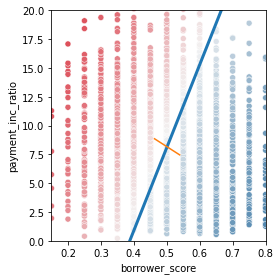

In [14]:
# [그림 5-1] 두 변수(채무자의 신용점수와 소득에 대한 지급 비율)를 사용한 연체에 대한 LDA 예측 결과
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

###### 주요개념
- 판별분석은 예측변수나 결과변수가 범주형이든 연속형이든 상관없이 잘 동작한다.
- 공분산행렬을 사용하여 한 클래스와 다른 클래스에 속한 데이터들을 구분하는 <b>선형판별함수, linear discriminant function</b>를 계산할 수 있다.
- 이 함수를 통해 각 레코드가 어떤 클래스에 속할 가중치 혹은 점수(각 클래스당 점수)를 구한다.

## 5.3 로지스틱 회귀

==========================================================================================================
###### 용어정리
- 로짓(logit): (0~1)이 아니라 +-무한대의 범위에서 어떤 클래스에 속할 확률을 결정하는 함수 (유의어: 로그오즈)
- 오즈(odds): '실패'(0)에 대한 '성공'(1)의 비율
- 로그 오즈(log odds): 변환 모델(선형)의 응답변수. 이 값을 통해 확률을 구한다.

==========================================================================================================

### 5.3.1 로지스틱 반응 함수와 로짓
 - 로그 오즈 함수, 또는 로짓 함수는 0과 1 사이의 확률 $p$를 -무한대 ~ +무한대까지의 값으로 매핑해준다.
 
$$ odds(Y=1) = \frac {p} {1-p} $$

$$ p = \frac {odds} {1+odds} $$

$$ odds(Y=1) = e^{\beta_0+\beta_1x_1+\beta_2x_2 + ... + \beta_qx_q} $$

$$ log(odds(Y=1)) = \beta_0+\beta_1x_1+\beta_2x_2 + ... + \beta_qx_q $$

### 5.3.2 로지스틱 회귀와 GLM

In [15]:
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV

In [16]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)


LogisticRegression(C=1e+42, solver='liblinear')

In [17]:
print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6378907886011287
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612183
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229710
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


### 5.3.3 일반화선형모형
<b>일반화선형모형(GLM, generalized linear model)</b>은 다음 두 가지 주요 구성 요소로 특징지어진다.
 - 확률분포 또는 분포군(로지스틱 회귀의 경우 이항분포)
 - 응답을 예측변수에 매핑하는 연결(혹은 변형) 함수(로지스틱 회귀의 경우 로짓)

### 5.3.4 로지스틱 회귀의 예측값

$$ \hat{Y} = log(odds(Y=1)) $$

$$ \hat{p} = \frac {1} {1+e^{-\hat{Y}}} $$

In [18]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757872     -0.760434
std        0.378093      0.390456
min       -2.769376     -3.538593
25%       -0.985739     -0.977207
50%       -0.697406     -0.688907
75%       -0.472183     -0.467069
max       -0.029485     -0.064753


In [19]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500000      0.500000
std        0.167354      0.167354
min        0.062701      0.029054
25%        0.373163      0.376361
50%        0.497875      0.502125
75%        0.623639      0.626837
max        0.970946      0.937299


### 5.3.5 계수와 오즈비 해석하기
- <b>오즈비</b>
$$ Odds Ratio = \frac {odds(Y=1|X=1)} {odds(Y=1|X=0)} $$

- 이진 요인변수 $X$가 있을 때, 위 식은 
- $X=1$일 때 $Y=1$인 경우의 오즈와 $X=0$일 때 $Y=1$인 경우의 오즈를 비교한 것
- 만약 오즈비가 2이면, 이것은 $X=1$일 때 $Y=1$인 경우의 오즈가 $X=0$일 때보다 두 배 더 높음을 의미

### 5.3.6 선형회귀와 로지스틱 회귀: 유사점과 차이점
- 공통점:
 - 예측변수와 응답변수를 선형 관계로 가정
 - 최적의 모델 탐색 과정도 유사
 - 스플라인 변환 방법은 로지스틱에도 적용 가능
 
- 차이점(로지스틱 회귀가 갖는 특징): 
 - 모델을 피팅하는 방식(최소제곱 사용 불가)
 - 모델에서 잔차의 특징과 분석
 
#### 모델피팅 
 - <b>최대우도추정(MLE, maximum likelihood estimation)</b> 활용 모델 피팅 
 - 최대우도추정이란, 우리가 보고 있는 데이터를 생성했을 가능성이 가장 큰 모델을 찾는  프로세스
 - 로지스틱 회귀식에서 응답변수는 0/1이 아니라, 응답이 1인 로그 오즈비의 추정치
 - MLE는 예상 로그 오즈비가 관찰된 결과를 가장 잘 설명하는 모델을 찾는다.

### 3.5.7 모델 평가하기


In [22]:
import statsmodels.api as sm

In [23]:
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Fri, 22 Oct 2021   Deviance:                       57515.
Time:                        22:44:39   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

In [24]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Fri, 22 Oct 2021   Deviance:                       57462.
Time:                                               22:45:42   Pearson chi2:                 4.54e+04
No. Iterations:                                            6                                         
Covariance Type:                                   nonrobust                      

#### 잔차분석

In [25]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

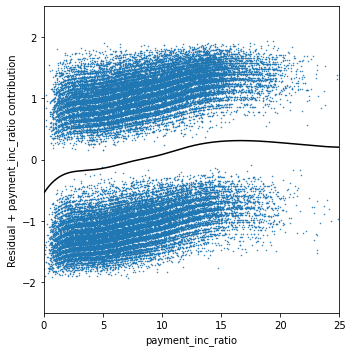

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

###### 주요개념
- 로지스틱 회귀는 출력이 이진변수라는 점만 빼면, 선형회귀와 매우 비슷하다.
- 선형모형과 비슷한 형태의 모델을 만들기 위해, 응답변수로 오즈비의 로그값을 사용하는 등의 몇 가지 변환이 필요하다.
- 반복 과정을 통해 선형모형을 피팅하고 나면, 로그 오즈비는 다시 확률값으로 변환된다.
- 로지스틱 회귀는 계산 속도가 빠르고 새로운 데이터에 대해서도 간단한 산술연산으로 빠르게 결과를 구할 수 있다는 장점 때문에 많이 사용된다.